This notebook studies the behavior of a group of 360 crystals in the same ieta ring over 3 years.

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker
#now lets try some autoregression
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.preprocessing import MinMaxScaler

In [2]:
#load in the data
test = pd.read_csv('/home/rusack/evans908/FAIR/scripts/slimmed_df_ieta66_2018.csv', index_col=0)
geom = pd.read_csv('/home/rusack/evans908/FAIR/ECAL_RADDAM_Data/geom/ecal_geom.csv', index_col=0)

/panfs/roc/msisoft/anaconda/python3-2020.07-mamba/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#simply way to process groups
def digest(grp):
    slimmed = grp[1][['calibration','laser_datetime']].copy()
    slimmed.loc[:,'laser_datetime'] = pd.to_datetime(slimmed.laser_datetime)
    return (grp[0], slimmed.reset_index()) #since different crystals in the ring will have slightly different times, you need to explicitly nuke the index to get them next to each other

In [4]:
grps = [digest(grp) for grp in test.groupby(test.index)]

In [5]:
multi_df = grps[0][1].copy()

for grp in grps:
  #  print(grp[0])
  #  print(grp[1])
    multi_df[grp[0]] = grp[1].calibration
multi_df_clean = multi_df.drop(['index','calibration','laser_datetime'],axis=1)

In [6]:
multi_df_clean

,54000,54001,54002,54003,54004,54005,54006,54007,54008,54009,...,54350,54351,54352,54353,54354,54355,54356,54357,54358,54359
0,0.937300,0.909478,0.936053,0.905632,0.915195,0.918712,0.923037,0.926793,0.926404,0.934636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.937845,0.909831,0.937014,0.906189,0.915627,0.919195,0.923768,0.927261,0.927101,0.934640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.936282,0.908763,0.935852,0.905231,0.914767,0.918117,0.922511,0.925716,0.926217,0.933663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.936760,0.909124,0.936407,0.905534,0.915339,0.918427,0.923324,0.926320,0.926396,0.934269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.937384,0.909618,0.936161,0.905823,0.914949,0.918734,0.923514,0.926480,0.926949,0.934822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9212,0.903612,0.872405,0.899671,0.865801,0.878405,0.879324,0.886165,0.889141,0.887202,0.899273,...,0.883647,0.856189,0.875220,0.908723,0.914361,0.918978,0.895350,0.863728,0.882331,0.888860
9213,0.906701,0.876512,0.902043,0.873546,0.883955,0.883022,0.891634,0.891653,0.891700,0.905891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9214,0.905441,0.875684,0.900803,0.872855,0.882984,0.882028,0.890556,0.890681,0.890536,0.905034,...,0.888923,0.858482,0.885084,0.914596,0.915812,0.924986,0.901562,0.872912,0.889641,0.894536
9215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
corr = multi_df_clean.corr()

In [8]:
corr.min().min()

-0.02911233116826624

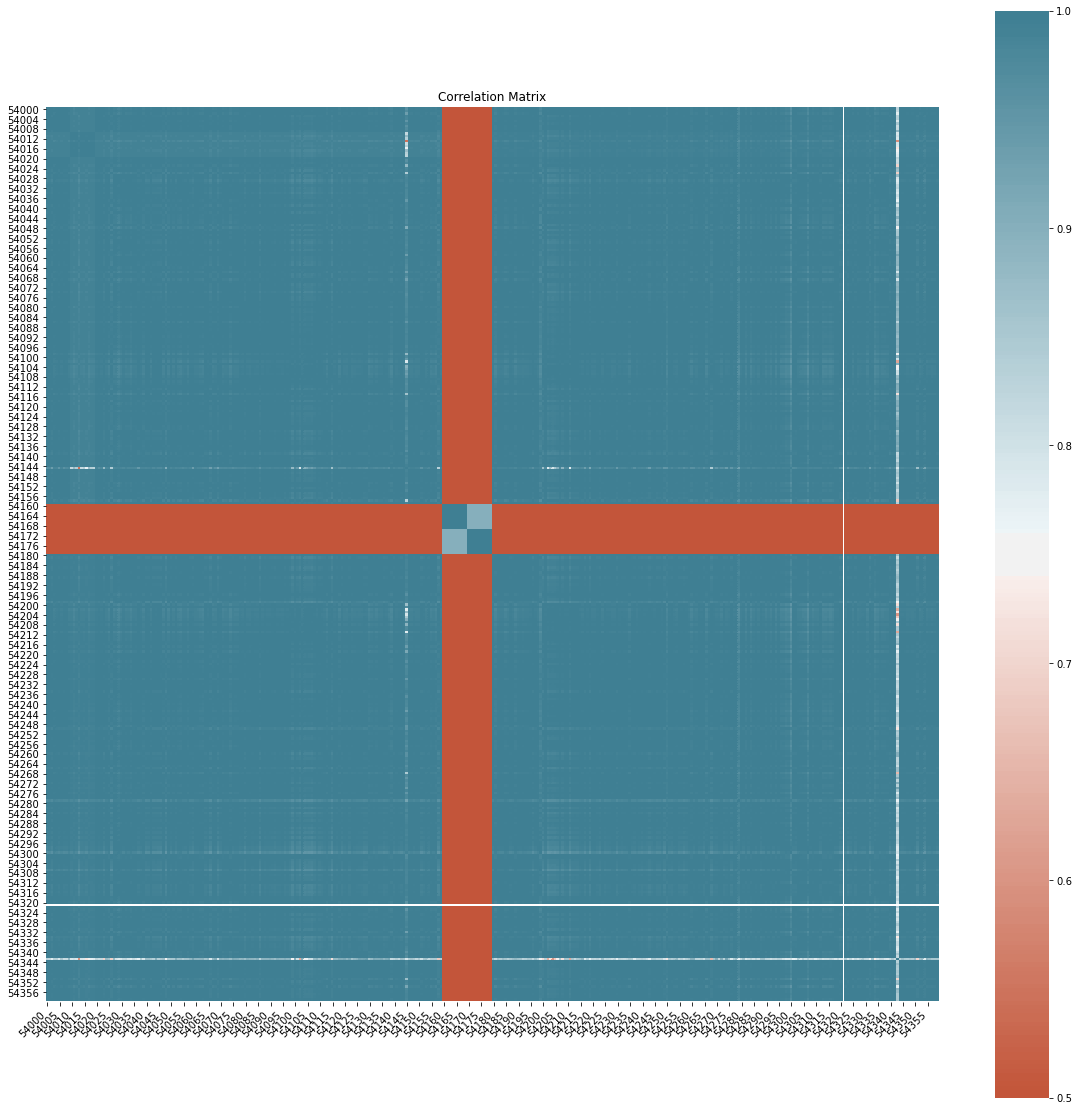

In [9]:
fig, ax = plt.subplots(figsize=(20,20))

ax.set_title('Correlation Matrix')
corr1 = multi_df_clean.corr()
ax = sns.heatmap(
    corr1, 
    vmin=0.50, vmax=1, center=0.75,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
#fix for matplotlib 3.1.1 issue (fixed in 3.1.2??)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [10]:
#let's build a combined view of all of the crystals
group = test.groupby(test.index)
calibrations = pd.concat([grp.reset_index()[['calibration']] for _,grp in group], axis=1)
datetimes = pd.concat([grp.reset_index()[['laser_datetime']] for _,grp in group], axis=1)
lumis = pd.concat([grp.reset_index()[['int_deliv_inv_ub']] for _,grp in group], axis=1)

In [17]:
datetimes

,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,...,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime
0,2018-02-07 16:15:53,2018-02-07 16:15:53,2018-02-07 16:15:53,2018-02-07 16:15:53,2018-02-07 16:15:53,2018-02-07 16:15:53,2018-02-07 16:15:53,2018-02-07 16:15:53,2018-02-07 16:15:53,2018-02-07 16:15:53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-02-07 17:28:57,2018-02-07 17:28:57,2018-02-07 17:28:57,2018-02-07 17:28:57,2018-02-07 17:28:57,2018-02-07 17:28:57,2018-02-07 17:28:57,2018-02-07 17:28:57,2018-02-07 17:28:57,2018-02-07 17:28:57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-02-07 17:53:45,2018-02-07 17:53:45,2018-02-07 17:53:45,2018-02-07 17:53:45,2018-02-07 17:53:45,2018-02-07 17:53:45,2018-02-07 17:53:45,2018-02-07 17:53:45,2018-02-07 17:53:45,2018-02-07 17:53:45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-02-07 18:18:33,2018-02-07 18:18:33,2018-02-07 18:18:33,2018-02-07 18:18:33,2018-02-07 18:18:33,2018-02-07 18:18:33,2018-02-07 18:18:33,2018-02-07 18:18:33,2018-02-07 18:18:33,2018-02-07 18:18:33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-02-07 19:00:07,2018-02-07 19:00:07,2018-02-07 19:00:07,2018-02-07 19:00:07,2018-02-07 19:00:07,2018-02-07 19:00:07,2018-02-07 19:00:07,2018-02-07 19:00:07,2018-02-07 19:00:07,2018-02-07 19:00:07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9212,2019-01-16 15:24:54,2019-01-16 15:24:54,2019-01-16 15:24:54,2019-01-16 15:24:54,2019-01-16 15:24:54,2019-01-16 15:24:54,2019-01-16 15:24:54,2019-01-16 15:24:54,2019-01-16 15:24:54,2019-01-16 15:24:54,...,2019-01-16 15:21:50,2019-01-16 15:21:50,2019-01-16 15:21:50,2019-01-16 15:21:50,2019-01-16 15:21:50,2019-01-16 15:21:50,2019-01-16 15:21:50,2019-01-16 15:21:50,2019-01-16 15:21:50,2019-01-16 15:21:50
9213,2019-03-13 11:32:40,2019-03-13 11:32:40,2019-03-13 11:32:40,2019-03-13 11:32:40,2019-03-13 11:32:40,2019-03-13 11:32:40,2019-03-13 11:32:40,2019-03-13 11:32:40,2019-03-13 11:32:40,2019-03-13 11:32:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9214,2019-03-13 11:43:54,2019-03-13 11:43:54,2019-03-13 11:43:54,2019-03-13 11:43:54,2019-03-13 11:43:54,2019-03-13 11:43:54,2019-03-13 11:43:54,2019-03-13 11:43:54,2019-03-13 11:43:54,2019-03-13 11:43:54,...,2019-03-13 11:50:47,2019-03-13 11:50:47,2019-03-13 11:50:47,2019-03-13 11:50:47,2019-03-13 11:50:47,2019-03-13 11:50:47,2019-03-13 11:50:47,2019-03-13 11:50:47,2019-03-13 11:50:47,2019-03-13 11:50:47
9215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    datetime_series = datetimes.apply(lambda x: pd.to_datetime(x).min(), axis=1)
    lumi_series = lumis.apply(lambda x: x.median(skipna=True), axis=1)
    calib_median_series = calibrations.apply(lambda x: x.median(), axis=1)
    calib_upper_series = calibrations.apply(lambda x: x.quantile(0.9), axis=1)
    calib_lower_series = calibrations.apply(lambda x: x.quantile(0.1), axis=1)

In [28]:
frame = {"datetime":datetime_series,"int_lumi":lumi_series,"calib_50":calib_median_series,"calib_90":calib_upper_series,"calib_10":calib_lower_series}

comb_df = pd.DataFrame(frame).dropna(subset=['datetime']) #we'll make a combined dataframe for all points that had a laser fire anywhere in the ring

In [29]:
comb_df.datetime = pd.to_datetime(comb_df.datetime)
#comb_df = comb_df.set_index('datetime').sort_index()
comb_df

,datetime,int_lumi,calib_50,calib_90,calib_10
0,2018-02-07 16:15:53,6.784826e+10,0.925882,0.963367,0.884449
1,2018-02-07 17:28:57,6.784826e+10,0.926003,0.963105,0.884008
2,2018-02-07 17:53:45,6.784826e+10,0.925657,0.963393,0.884804
3,2018-02-07 18:18:33,6.784826e+10,0.925902,0.963630,0.883984
4,2018-02-07 19:00:07,6.784826e+10,0.923319,0.965480,0.879695
...,...,...,...,...,...
9211,2019-01-16 14:57:17,6.784826e+10,0.890800,0.926055,0.854226
9212,2019-01-16 15:21:50,6.784826e+10,0.891466,0.926055,0.853940
9213,2019-03-13 11:32:40,6.784826e+10,0.897788,0.929683,0.860040
9214,2019-03-13 11:43:54,6.784826e+10,0.893794,0.925649,0.860754


In [31]:
comb_df.sort_values(by=['datetime'])

,datetime,int_lumi,calib_50,calib_90,calib_10
0,2018-02-07 16:15:53,6.784826e+10,0.925882,0.963367,0.884449
1,2018-02-07 17:28:57,6.784826e+10,0.926003,0.963105,0.884008
2,2018-02-07 17:53:45,6.784826e+10,0.925657,0.963393,0.884804
3,2018-02-07 18:18:33,6.784826e+10,0.925902,0.963630,0.883984
4,2018-02-07 19:00:07,6.784826e+10,0.923319,0.965480,0.879695
...,...,...,...,...,...
9211,2019-01-16 14:57:17,6.784826e+10,0.890800,0.926055,0.854226
9212,2019-01-16 15:21:50,6.784826e+10,0.891466,0.926055,0.853940
9213,2019-03-13 11:32:40,6.784826e+10,0.897788,0.929683,0.860040
9214,2019-03-13 11:43:54,6.784826e+10,0.893794,0.925649,0.860754


In [51]:
comb_df.to_csv('2018_ring66_comb.csv')

In [36]:
check = pd.read_csv('../scripts/matching_check_2018_54000.csv')
check = check.dropna()

In [ ]:
#now lets make a plot of the data
fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_ylabel('Crystal calibration value')
ax1.set_xlabel('FED firing time')
#ax1.set_ylim([0.87,0.94])
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data



ax1.scatter(check.ls_time, check.int_deliv_inv_ub, 
         label='lumi-section', color='red', s=8, linestyle='solid')
ax1.scatter(check.laser_datetime, check.int_deliv_inv_ub, 
         label='laser', color='red', s=8, linestyle='solid')

#combined legend
fig.legend(ncol=5, loc = (0.22,0.18),framealpha=1)

fig.show()